200


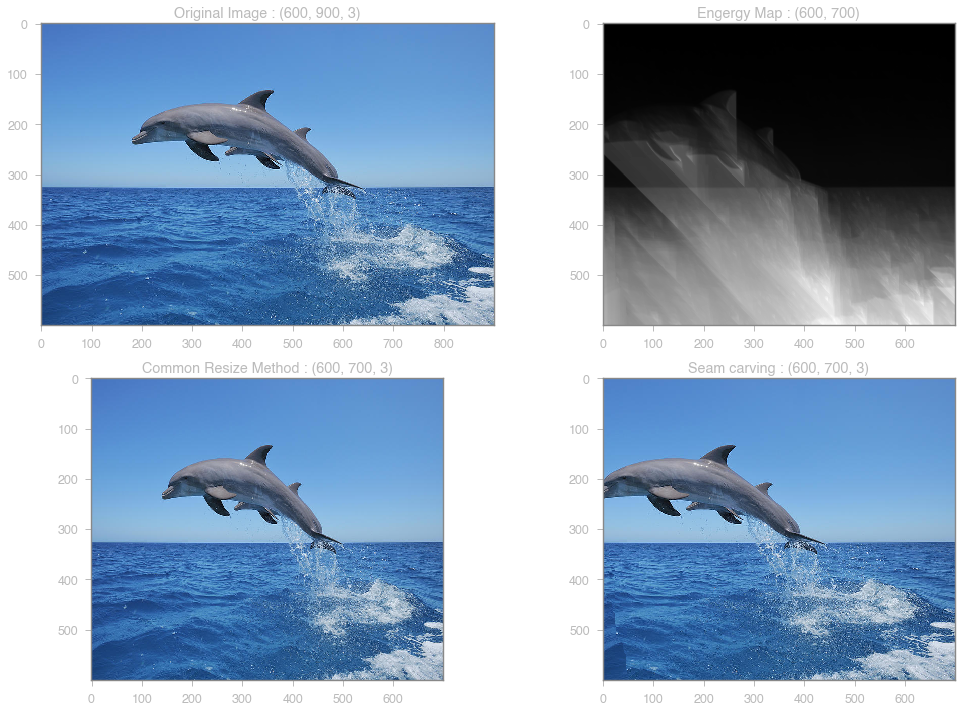

200


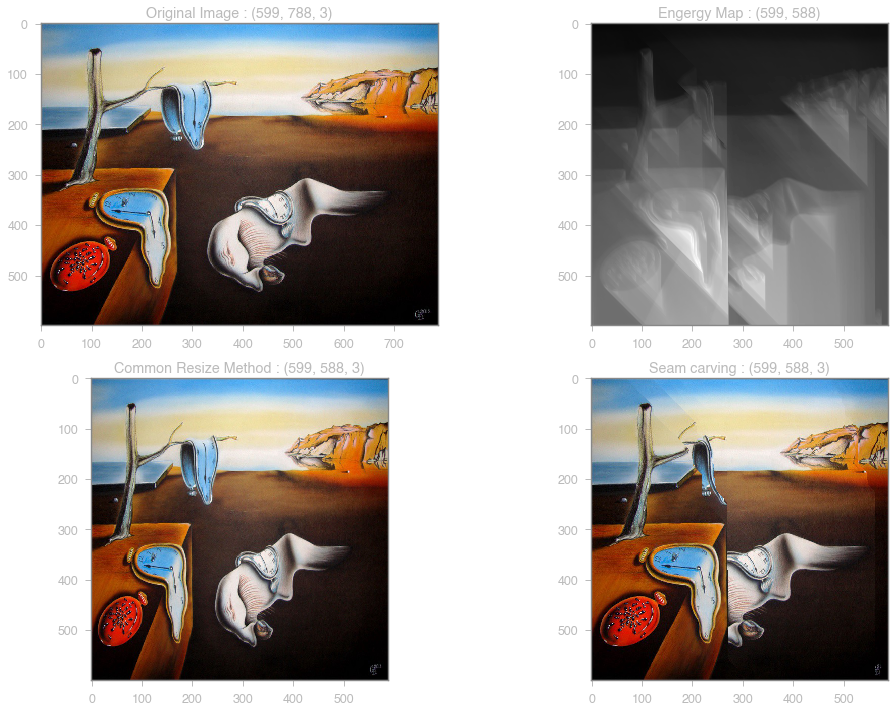

200


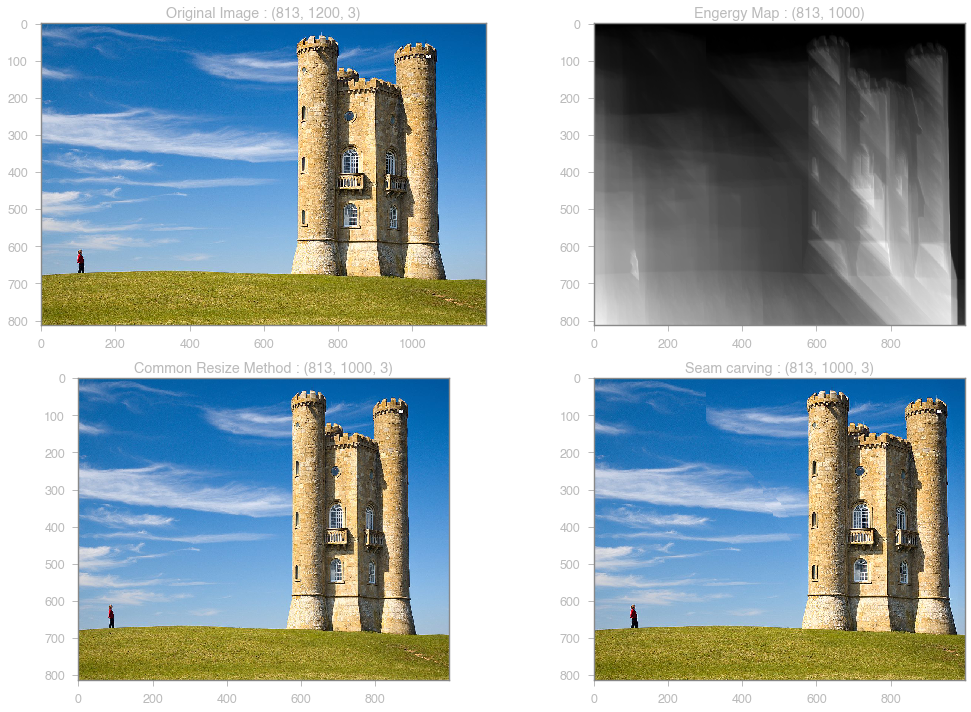

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ipywidgets import interact, widgets

img_names = ['dolphine.jpg', 'paint.jpg', 'tower.jpg']
kernel_size=11

def preprocess(img_name):
    img = mpimg.imread(img_name)
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 2)
    return img, blurred

def edge(gray):
    sobel_x = np.abs(cv2.Sobel(gray, 3, 1, 0)).astype(np.uint32)
    sobel_y = np.abs(cv2.Sobel(gray, 3, 0, 1)).astype(np.uint32)
    sobel = np.clip(np.sqrt(np.square(sobel_x)+np.square(sobel_y)), 0, 255).astype(np.uint8)
    return sobel

def produce_emp(edge):
    h, w = edge.shape
    result_edge = np.zeros((h,w))
    result_edge[0,:] = edge[0,:]
#     result_edge[-1,:] = edge[-1,:]
    for i in range(1, h):
#         current = edge[i, :]
        next_ = edge[i, :]
        for j in range(w):
            left = max(0, j-1)
            right = min(j+1, w-1)
            result_edge[i, j] = np.min(result_edge[i-1, left:right] + next_[j])
    result_edge = (result_edge/np.max(result_edge))
    return result_edge


def find_seam(emp, start=400):
    h, w = emp.shape
    current = start
    result = [current]
    for i in range(h-2, -1, -1):
        left = max(0, current-1)
        right = min(current+1, w-1)
        current += np.argmin(emp[i, left:right]) - 1
        current = max(0, min(current, w-1))
        result.append(current)
    return np.array(result)

def remove_seam(img, emp, seam_index):
    h, w, d = img.shape
    img_ = np.zeros((h, w-1, d), dtype=np.uint8)
    emp_ = np.zeros((h, w-1))
    for i in range(len(seam_index)):
        seam_ = seam_index[i]
        img_[h-(i+1), :seam_, :] = img[h-(i+1), :seam_, :]
        img_[h-(i+1), seam_:, :] = img[h-(i+1), seam_+1:, :]
        emp_[h-(i+1), :seam_] = emp[h-(i+1), :seam_]
        emp_[h-(i+1), seam_:] = emp[h-(i+1), seam_+1:]
    return img_, emp_


num_reduce = 150
for img_name in img_names:
    plt.figure(figsize=(15,10))
    image, gray = preprocess(img_name)
    img_copy = np.copy(image)
    sobel = edge(gray)
    emp = produce_emp(sobel)

    for i in range(num_reduce):
        h, w = emp.shape
        start = np.argmin(emp[-1, 3:int(w*0.98)]) + 3
        seam_index = find_seam(emp, start)
        image, emp = remove_seam(image, emp, seam_index)
        
    print(num_reduce)
    h, w, _ = image.shape
    resized = cv2.resize(img_copy, (w, h))
    plt.subplot(221);plt.imshow(img_copy);plt.title(f"Original Image : {img_copy.shape}")
    plt.subplot(222);plt.imshow(emp, cmap='gray');plt.title(f"Engergy Map : {emp.shape}")
    plt.subplot(223);plt.imshow(resized, cmap='gray');plt.title(f"Common Resize Method : {resized.shape}")
    plt.subplot(224);plt.imshow(image);plt.title(f"Seam carving : {image.shape}")
    plt.tight_layout()
    plt.show()